# Stacjonarność


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm

Wczytajmy dane

In [3]:
data = pd.Series.from_csv('./AirPassengers.csv', header=0).astype(np.float64)
print(data.head())
print('\n Data Types:')
print(data.dtypes)

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64

 Data Types:
float64


C:\Users\przem\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [4]:
data['1949-01-01':'1949-05-01']

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64

In [5]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

# Jak sprawdzić stacjonarność szergu czasowego?
 
Stacjonarność jest określona przy użyciu bardzo skomplikowanych kryteriów. Jednak w celach praktycznych można założyć, że szereg czasowy jest stacjonarny, jeśli ma stałe właściwości statystyczne w czasie, tj. następujące:

- stała średnia
- stała wariancja
- autokowariancja nie zależy od czasu.


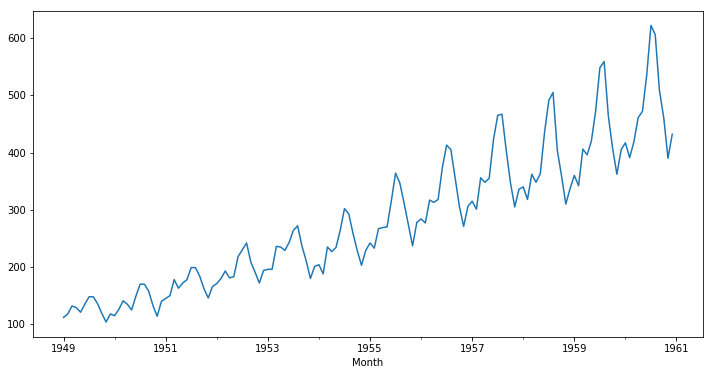

In [8]:
plt.figure(figsize=(12,6));
data.loc['1949':].plot()
plt.show()

Jest oczywiste, że istnieje ogólna tendencja wzrostowa w danych wraz z sezonowymi wahaniami. Jednak nie zawsze możliwe jest takie wizualne wnioskowanie (zobaczymy takie przypadki później). Więc bardziej formalnie możemy sprawdzić stacjonarność używając:

- możemy wyznaczyć średnią ruchomej lub ruchomą wariancji i sprawdzić, czy zmienia się ona z czasem. Średnia ruchoma lub ruchoma wariancja oznacza, że w każdej chwili 't' przeanalizujemy średnią /wariancję z ostatniego roku, tzn. w ciągu ostatnich 12 miesięcy. Ale znowu jest to bardziej wizualna technika.

- Test Dickey-Fuller: jest to jeden ze statystycznych testów sprawdzających stacjonarność. Tutaj hipoteza zerowa to, że szereg czasowy jest niestacjonarny. 
Wyniki testu obejmują statystykę testu oraz niektóre wartości krytyczne dla różnych poziomów ufności. Jeśli statystyka testowa jest mniejsza niż  wartość krytyczna, możemy odrzucić hipotezę zerową i powiedzieć, że szereg czasowy jest stacjonarny. 

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()#.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(12,6));
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

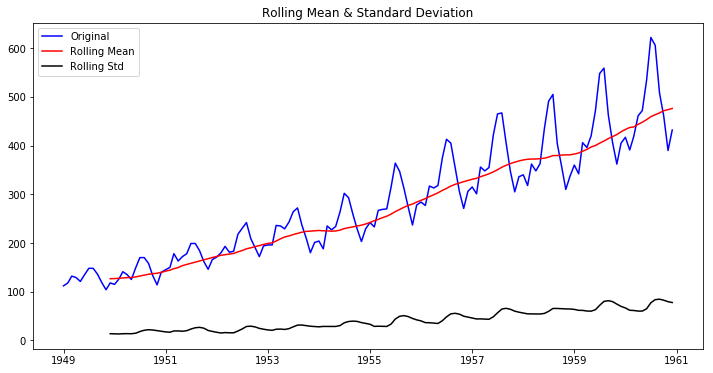

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [11]:
test_stationarity(data)

# Jak przetrasformować szerga czasowy tak by był stacjonarny?

Chociaż założenie stacjonarności jest przyjmowane w wielu modelach TS, w praktyce żaden szereg czasowy nie jest stacjonarny. Mamy sposoby, aby szereg stał się stacjonarny. Należy pamiętać, że jest to prawie nie możliwe, ale staramy się doprowadzić do sytuacji w której jest on jak najbliżej bycia stacjonarnym.

Istnieją dwa główne powody, które powodują niestacjonarność:

1. Trend - zmienna średnia w czasie. Na przykład, w naszym przypadku zauważyliśmy, że przeciętnie liczba pasażerów rośnie z upływem czasu.

2. Sezonowość - zmiany w określonych przedziałach czasowych. Np. Ludzie mogą mieć skłonność do zakupu samochodów w danym.

Podstawową zasadą jest modelowanie lub szacowanie trendu i sezonowości w szeregu czasowym oraz usunięcie ich, aby uzyskać stacjonarne szeregi czasowe. Następnie dla takiego szeregu czasowego można zastosować modele statystyczne. Ostatnim krokiem byłoby przekształcenie prognozowanych wartości do pierwotnej skali poprzez dodanie trendu i sezonowości.

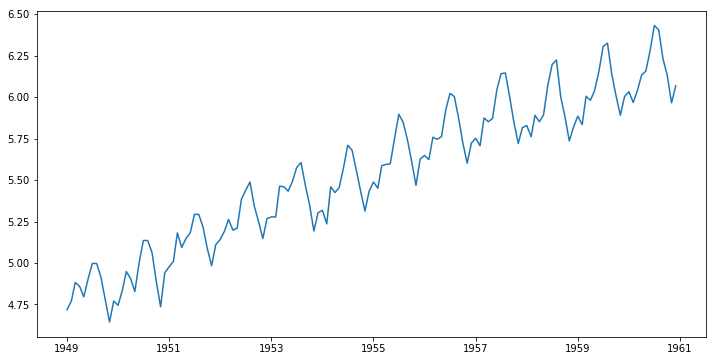

In [12]:
ts_log = np.log(data)
plt.figure(figsize=(12,6));
plt.plot(ts_log)
plt.show()

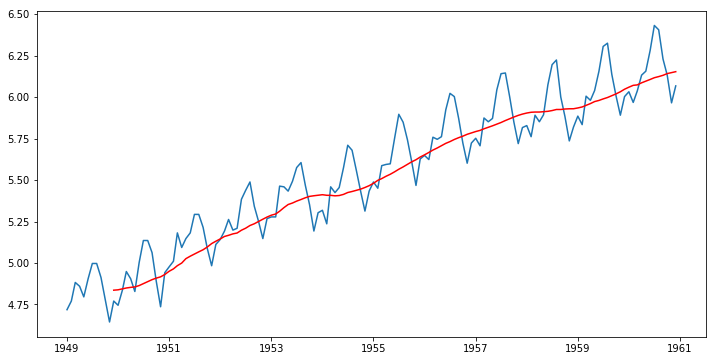

In [13]:
moving_avg = ts_log.rolling(12).mean()
plt.figure(figsize=(12,6));
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

Pamiętajmy, że w przypadku średniej kroczącej nie mamy wyników dla kilku pierwszych wartości.

In [14]:
ts_log_moving_avg_diff = ts_log - moving_avg
print(ts_log_moving_avg_diff.head(12))
ts_log_moving_avg_diff.dropna(inplace=True)
print(ts_log_moving_avg_diff.head(12))

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64
Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
Name: #Passengers, dtype: float64


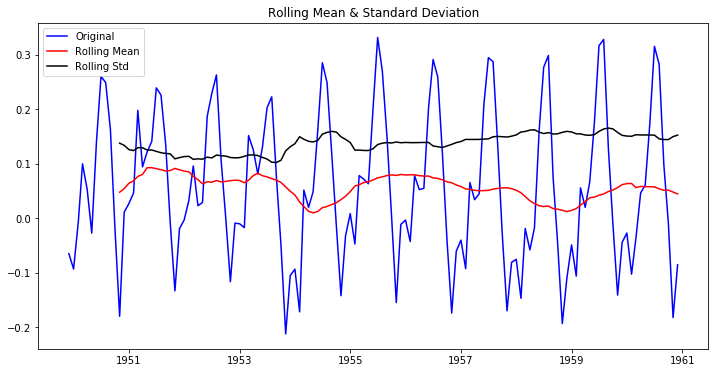

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [15]:
test_stationarity(ts_log_moving_avg_diff)

Nasz szereg wygląda znacznie lepiej. Wartości średniej różnią się nieznacznie, ale nie ma określonego trędu. Ponadto statystyka testowa jest mniejsza niż $5\%$ wartości krytycznych, dzięki czemu możemy stwierdzić z $95\%$ pewnością, że jest to szereg stacjonarny.

## Średnia ważona 

Jednakże wadą w tym szczególnym podejściu jest to, że okres czasu musi być ściśle określony. W tym przypadku możemy przyjąć średnie roczne, ale w skomplikowanych sytuacjach, takich jak prognozowanie cen akcji, trudno jest dobrać tą stałą. 

Przyjmujemy zatem "ważoną średnią ruchliwą", gdzie bliższe wartości mają wyższe wagi. Istnieje wiele technik przypisywania wag. My użyjemy średniej harmonicznej.

http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions

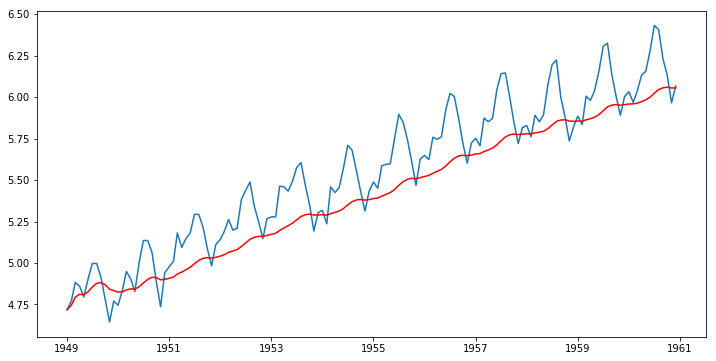

In [18]:
expwighted_avg = ts_log.ewm(halflife=12).mean()

plt.figure(figsize=(12,6));
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.show()

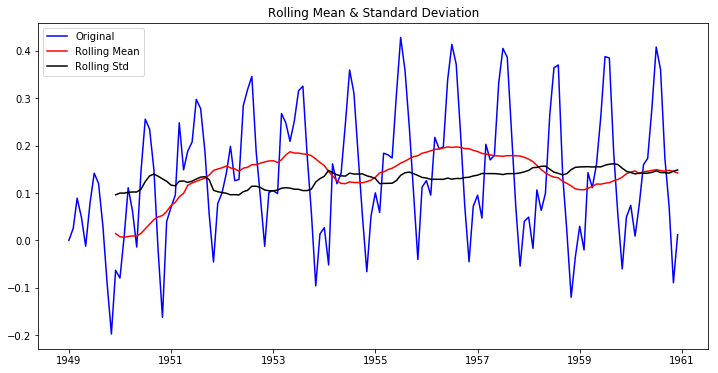

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [19]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

Ten szereg czasowy ma nawet mniejsze odchylenia średniej i variancji. Ponadto statystyka testowa jest mniejsza niż wartość krytyczna $1\%$, która jest lepsza niż poprzednia. Zauważ, że w tym przypadku nie ma brakujących wartości, ponieważ wszystkie wartości od startu są podawane. 

# Differencing

Jedną z najczęstszych metod radzenia sobie z trendu i sezonowości jest różnicowanie. W tej technice w każdej chwili czasowej rozważamy  różnicę w obserwacji z tą z poprzedniej chwili. Działa to głównie poprawiając stacjonarność. 

# Wykonaj różnicowanie na zlogarytmowanych danych.

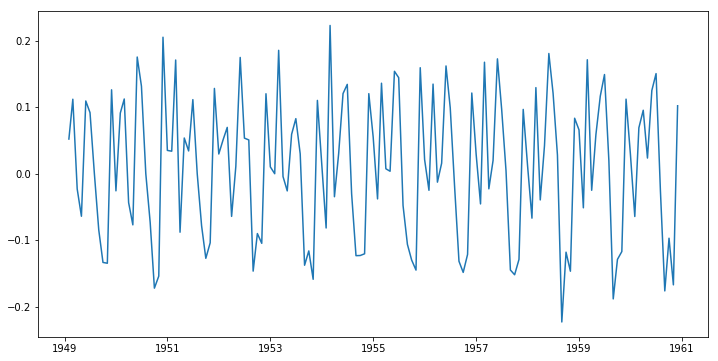

In [20]:
plt.figure(figsize=(12,6));
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

# Zad.
Sprawdź czy szereg czasowy jest już stacjonarny.

In [21]:
ts_log_diff.dropna(inplace=True)

# Zad.
Wykonaj różnicowanie kilka razy i sprawdź, czy uzyskasz lepszy wynik. 